In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
# Check what physical devices are available
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load and prepare the data

In [3]:
life_expectancy_data = pd.read_csv(Path("./data/life_expectancy_who.csv"))

In [4]:
def create_feature_and_target_data(life_expectancy_data: pd.DataFrame) -> (np.array, np.array):
    """Create feature and target TensorFlow tensors from life expectancy data.

    Args:
        dataframe: Life expectancy data downloaded from Kaggle kumarajarshi/life-expectancy-who.

    Returns:
        X, y the features and target data.
    """
    # Rename columns to remove spaces and make lowercase
    life_expectancy_data.columns = [column.lower().strip().replace(" ", "_") for column in life_expectancy_data.columns]

    # Extract specific columns from dataframe
    feature_columns = [
        "alcohol",
        "bmi",
        "polio",
        "total_expenditure",
        "diphtheria",
        "hiv/aids",
        "gdp",
        "population",
        "income_composition_of_resources",
        "schooling",
    ]
    target_column = "life_expectancy"
    columns = [*feature_columns, target_column]

    processed_dataframe = (
        life_expectancy_data.filter(columns)  # Filter columns
        .dropna(axis=0)  # Remove rows with NaN values
        .assign(gdp_per_capita=lambda df: df["gdp"] / df["population"])  # Create new column dividing gdp by population
        .drop(columns=["gdp", "population"])  # Drop gdp and population columns
    )

    # Create features and target data
    X = processed_dataframe.drop(columns=[target_column]).to_numpy()
    y = processed_dataframe[target_column].to_numpy()

    return X, y

In [5]:
X, y = create_feature_and_target_data(life_expectancy_data)
X.shape, y.shape

((2094, 9), (2094,))

In [6]:
# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to TensorFlow constant tensors
X_train, y_train = tf.constant(X_train, dtype=tf.float32), tf.constant(y_train, dtype=tf.float32)
X_test, y_test = tf.constant(X_test, dtype=tf.float32), tf.constant(y_test, dtype=tf.float32)

2024-01-13 16:16:25.182488: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-13 16:16:25.182508: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-13 16:16:25.182512: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-13 16:16:25.182544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 16:16:25.182559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Linear regression model

We will fit a simple model of the form

$$
y = h_\theta(\mathbf{x}) + \epsilon,

$$

where $y\in\mathbb{R}$ is the target variable, $\mathbf{x}\in\mathbb{R}^{9}$ are the input features, $\theta\in\mathbb{R}^{10}$ are the model parameters, $\epsilon\sim\mathcal{N}(0, 1)$ is the observation noise random variable, and $f_\theta:\mathbb{R}^{9}\mapsto\mathbb{R}$ is given by

$$
\begin{align}
h_\theta(\mathbf{x}) &= \theta_0 + \sum_{m=1}^{9} \theta_m x_m\\
&= \sum_{m=0}^{10} \theta_m x_m.
\end{align}
$$

In the second line above we have defined $x_0=1$ to be the constant feature. 

### MLE Normal Equations

The maximum likelihood solution is given by the normal equation

$$
\theta_{ML} = \left(\mathbf{X}^T \mathbf{X}\right)^{-1}\mathbf{X}^T\mathbf{y},
$$

where $\mathbf{X}\in\mathbb{R}^{N\times M}$ is the data matrix, $\mathbf{y}\in\mathbb{R}^N$ are the targets, $N$ is the number of data examples, and $M$ are the number of features (including the constant feature).

In [21]:
def normal_equation_tf(X: tf.constant, y: tf.constant) -> tf.Variable:
    """Calculate parameters using normal equations.

    Args:
        X: Features tensor
        y: Target tensor
    """
    ones = tf.ones([X.shape[0], 1], dtype=X.dtype)
    X_bias = tf.concat([ones, X], axis=1)
    X_bias_T = tf.transpose(X_bias)
    XTX = tf.tensordot(X_bias_T, X_bias, axes=[[1], [0]])
    inv_XTX = tf.linalg.inv(XTX)
    inv_XTX_XT = tf.tensordot(inv_XTX, X_bias_T, axes=[[1], [0]])

    return tf.tensordot(inv_XTX_XT, y, axes=[[1], [0]])

In [8]:
normal_equation_tf(X_train, y_train)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 6.8760109e+01, -5.7007843e-01,  1.2628831e+00,  4.1321987e-01,
        6.6628486e-02,  6.1053598e-01, -3.6856465e+00,  2.5225701e+00,
        3.8683507e+00,  2.7549013e-01], dtype=float32)>

## Gradient Descent

We define the loss function as the Mean Squared Error

$$ J(\theta)=\frac{1}{n}\sum_{i=1}^{n}(h_{\theta}(\mathbb{x^{(i)}})-y^{(i)})^2$$

Our goal is to minimise $J_\theta$ with respect to $\theta$

$$\underset{\theta}{\text{minimise }}J(\theta)$$


The update step of Gradient Descent is
$$
\theta_{m, t+1} = \theta_{m, t} - \eta \nabla_\theta {L}_{MSE}(\theta_{m, t})
$$

where $\eta>0$ is the learning rate and $t$ is the iteration.

In [9]:
def calc_y_pred(bias: tf.Variable, weights: tf.Variable, X: tf.constant) -> tf.constant:
    """Calculate y_pred using Linear Regression.

    Args:
        bias: The bias term in the Linear Regression equation.
        weights: The weights in the Linear Regression equation.
        X: The features tensor.

    Returns:
        The predicted values.
    """
    return bias + tf.tensordot(X, weights, axes=[[1], [0]])

In [19]:
# given
bias = tf.Variable(1.0)
weights = tf.Variable([2.0, 3.0])
inputs = tf.constant([[1.0, 2.0], [3.0, 4.0]])

# when
result = calc_y_pred(bias, weights, inputs).numpy()

# then
expected = np.array([9.0, 19.0])
assert (result == expected).all()

In [11]:
def calc_mse(y_actuals: tf.constant, y_pred: tf.constant) -> tf.constant:
    """Calculate_mean_squared_error.

    Args:
        y_pred: The predicted values.
        y_actuals: The actual values.

    Returns:
        The mean squared error.
    """
    return tf.reduce_mean(tf.square(y_actuals - y_pred))

In [12]:
# given
preds = tf.constant([1.0, 1.0, 1.0, 1.0])
actuals = tf.constant([1.0, 1.0, 11.0, 1.0])

# when
result = calc_mse(actuals, preds).numpy()

# then
expected = 25.0
assert result == expected

In [13]:
def update_parameters(
    bias: tf.Variable, weights: tf.Variable, X_train: tf.constant, y_train: tf.constant, learning_rate: float
):
    """Update parameters using Gradient Descent.

    Args:
        bias: The bias term in the Linear Regression equation.
        weights: The weights in the Linear Regression equation.
        X_train: The input training data.
        y_train: The actual target values for training.
        learning_rate: The learning rate for Gradient Descent.
    """
    with tf.GradientTape() as tape:
        # Calculate the current predictions
        y_pred = calc_y_pred(bias, weights, X_train)

        # Calculate the loss (mean squared error)
        loss = calc_mse(y_train, y_pred)

    # Compute the gradients of loss with respect to bias and weights
    dLoss_dbias, dLoss_dweights = tape.gradient(loss, [bias, weights])

    # Update the parameters
    bias.assign_sub(learning_rate * dLoss_dbias)
    weights.assign_sub(learning_rate * dLoss_dweights)

In [20]:
def gradient_descent(
    n_iterations: int,
    X_train: tf.constant,
    y_train: tf.constant,
    iteration: tf.Variable,
    bias: tf.Variable,
    weights: tf.Variable,
) -> list:
    """Perform Gradient Descent to find optimal parameters of a Linear Regression.

    Args:
        n_iterations: The number of gradient descent iterations.
        X_train: The input training data.
        y_train: The actual target values for training.
        iteration: A variable to track the current iteration.
        bias: Randomly initialised bias term of the model.
        weights: Randomly initialised weights of the model.

    Returns:
        List of Mean Squared Error for each iteration.
    """
    learning_rate = 0.01
    losses = []

    for i in range(n_iterations):
        update_parameters(bias, weights, X_train, y_train, learning_rate)
        y_pred = calc_y_pred(bias, weights, X_train)
        loss = calc_mse(y_train, y_pred)
        losses.append(loss.numpy())
        if i % 100 == 0:
            print(f"Iteration: {i}, Loss: {loss.numpy()}")
        iteration.assign_add(1)

    print("Training completed!")

    return losses

In [15]:
bias_grad_desc = tf.Variable(0.0, dtype=tf.float32, name="bias", trainable=True)
weights_grad_desc = tf.Variable(tf.random.normal([9]), dtype=tf.float32, name="bias", trainable=True)
iteration = tf.Variable(0, dtype=tf.int32, name="iteration", trainable=False)

In [16]:
losses = gradient_descent(
    n_iterations=2000,
    X_train=X_train,
    y_train=y_train,
    iteration=iteration,
    bias=bias_grad_desc,
    weights=weights_grad_desc,
)

Iteration: 0, Loss: 4646.103515625
Iteration: 100, Loss: 100.03033447265625
Iteration: 200, Loss: 20.25514793395996
Iteration: 300, Loss: 18.67815589904785
Iteration: 400, Loss: 18.608997344970703
Iteration: 500, Loss: 18.595430374145508
Iteration: 600, Loss: 18.590682983398438
Iteration: 700, Loss: 18.588687896728516
Iteration: 800, Loss: 18.5877742767334
Iteration: 900, Loss: 18.58733367919922
Iteration: 1000, Loss: 18.587116241455078
Iteration: 1100, Loss: 18.58700942993164
Iteration: 1200, Loss: 18.586956024169922
Iteration: 1300, Loss: 18.586931228637695
Iteration: 1400, Loss: 18.586915969848633
Iteration: 1500, Loss: 18.586910247802734
Iteration: 1600, Loss: 18.58690643310547
Iteration: 1700, Loss: 18.58690643310547
Iteration: 1800, Loss: 18.586902618408203
Iteration: 1900, Loss: 18.586904525756836
Training completed!


### Check if loss converges

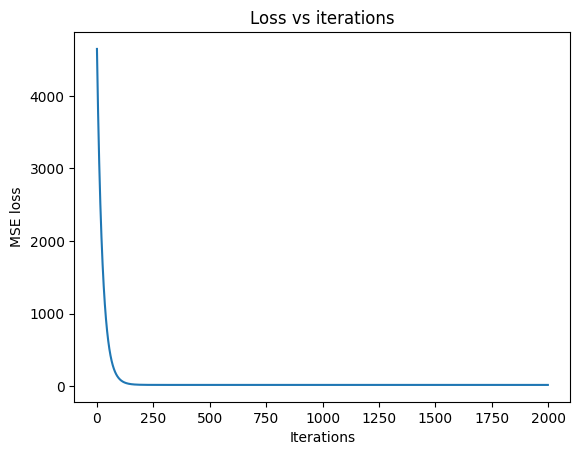

In [17]:
plt.plot(losses)
plt.title("Loss vs iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.show()

## Compare Normal Equations Parameters to Gradient Descent Parameters

In [18]:
comparison = pd.DataFrame(
    {
        "normal_equation_parameters": normal_equation_tf(X_train, y_train),
        "gradient_descent_parameters": np.hstack([bias_grad_desc.numpy(), weights_grad_desc.numpy()]),
    }
).assign(difference=lambda df: df["normal_equation_parameters"] - df["gradient_descent_parameters"])

comparison.round(4)

,normal_equation_parameters,gradient_descent_parameters,difference
0,68.760101,68.759903,0.0002
1,-0.570100,-0.570000,-0.0001
2,1.262900,1.263000,-0.0001
3,0.413200,0.413300,-0.0000
4,0.066600,0.066700,-0.0000
5,0.610500,0.610500,0.0000
6,-3.685600,-3.685600,-0.0000
7,2.522600,2.523200,-0.0007
8,3.868400,3.867500,0.0008
9,0.275500,0.275500,-0.0000
